# Titanic Survival

## Data source
- https://www.kaggle.com/c/titanic/data

## References
- http://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart
- http://chrisstrelioff.ws/sandbox/2015/06/08/decision_trees_in_python_with_scikit_learn_and_pandas.html
- https://www.kaggle.com/startupsci/titanic-data-science-solutions
- http://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html
- http://scikit-learn.org/stable/modules/ensemble.html
- http://scikit-learn.org/stable/modules/svm.html#support-vector-machines
- https://en.wikipedia.org/wiki/Support_vector_machine

### Modules

In [43]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier

### Import data

In [44]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('gender_submission.csv')
complete = [train, test]

### Describe data

In [45]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [46]:
print(train.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


Features

1. Categorical Features: 
    
    - Nominal: Survived, Sex, Embarked
    - Ordinal: Pclass

2. Numerical Features:
    
    - Continuous: Age, Fare
    - Discrete: SibSp, Parch
    - Timeseries: None

3. Others: Name, Ticket, Cabin

In [47]:
train.info()
print('-' * 40)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

Datatypes

    - Strings datatype: Name, Sex, Ticket, Cabin, Embarked
    - Numerical datatype: Survived, Pclass, Age, SibSp, Parch, Fare

Empty Values:
    
1. train: Age, Cabin, Embarked
2. test: Age, Fare, Cabin

In [48]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [49]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Carter, Mrs. Ernest Courtenay (Lilian Hughes)",male,1601,C23 C25 C27,S
freq,1,577,7,4,644


### Feature Engineering

#### 1. Pclass
    
    - class 1 has higher survival rate ~62%
    - class 3 has low survival rate ~24%
    - High correlation between Pclass and Survived, include the feature Pclass

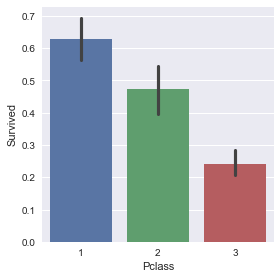

In [50]:
sns.factorplot(
    x='Pclass',
    y='Survived',
    data=train,
    kind='bar'
)

In [51]:
train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [52]:
_.corr()

,Pclass,Survived
Pclass,1.000000,-0.994024
Survived,-0.994024,1.000000


Pclass = 1 survived more, Pclass = 3 survived less; however lots of Pclass = 3 infants survived. And lots of Pclass = 3 aged 15-30 people died

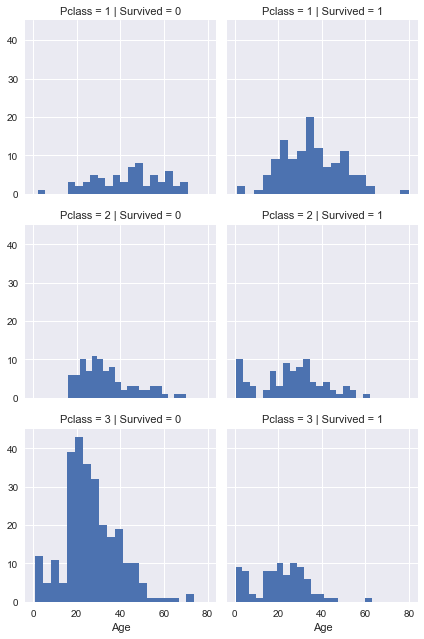

In [53]:
grid_1 = sns.FacetGrid(train, col='Survived', row='Pclass')
grid_1.map(plt.hist, 'Age', bins=20)

#### 2. Gender (Sex)

    - female has much higher survival rate
    - high correlation between Sex and Survived, include the feature Sex
    - create mapping for Sex

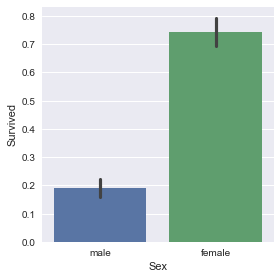

In [54]:
sns.factorplot(
    x='Sex',
    y='Survived',
    data=train,
    kind='bar'
)

In [55]:
train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [56]:
gender_mapping = {
    'male': 0,
    'female': 1
}

for dataset in complete:
    dataset['Sex'] = dataset['Sex'].map(gender_mapping).astype(np.int)
    
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S


#### 3. SibSp / Parch (IsAlone)

    - people alone has lower survival rate
    - though people not alone has higher survival rate, but the rate varies a lot as well
    - high to moderate correlation between SibSb / Parch and Survived, include the features
    - Combine existing 'SibSp' and 'Parch' to create new feature

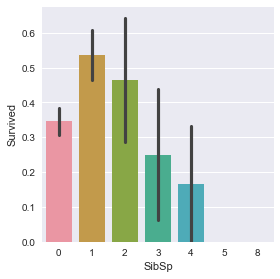

In [57]:
sns.factorplot(
    x='SibSp',
    y='Survived',
    data=train,
    kind='bar'
)

In [58]:
train[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [59]:
_.corr()

,SibSp,Survived
SibSp,1.000000,-0.851638
Survived,-0.851638,1.000000


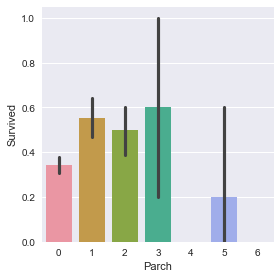

In [60]:
sns.factorplot(
    x='Parch',
    y='Survived',
    data=train,
    kind='bar'
)

In [61]:
train[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


In [62]:
_.corr()

,Parch,Survived
Parch,1.000000,-0.681289
Survived,-0.681289,1.000000


Binning/Converting Numerical to Categorical Variable, reducing noise or non-linearity, referencing [Enhance Machine Learning with Standardizing, Binning, Reducing](http://data-informed.com/enhance-machine-learning-with-standardizing-binning-reducing/)

In [63]:
for dataset in complete:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean()

,FamilySize,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


In [64]:
for dataset in complete:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [65]:
train = train.drop(['SibSp', 'Parch', 'FamilySize'], axis=1)
test = test.drop(['SibSp', 'Parch', 'FamilySize'], axis=1)
complete = [train, test]

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,PC 17599,71.2833,C85,C,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,113803,53.1000,C123,S,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,373450,8.0500,NaN,S,1


#### 4. Age

    - Infants survived more, lots of 15-30 people died, include the feature Age
    - Guess age based on Pclass and gender with age median values
    - Also tried using obviously out-of-range value -1 for NA, no big difference though
    

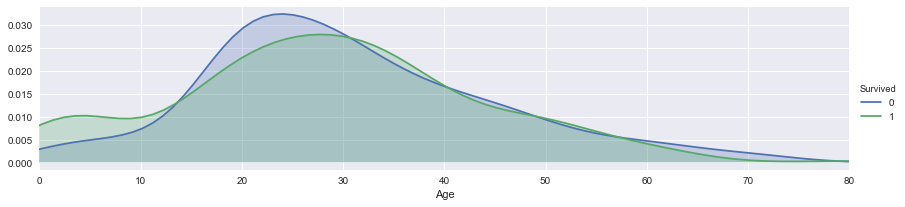

In [66]:
facet = sns.FacetGrid(
    data=train,
    hue='Survived',
    aspect=4
)
facet.map(sns.kdeplot, 'Age', shade=True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()

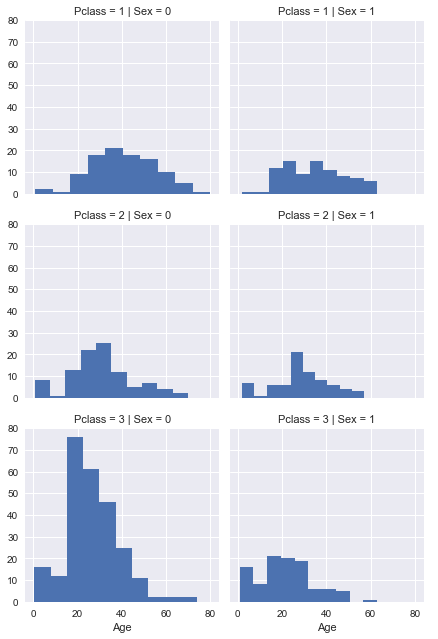

In [67]:
grid_3 = sns.FacetGrid(train, row='Pclass', col='Sex')
grid_3.map(plt.hist, 'Age')
grid_3.add_legend()

In [68]:
#  Also tried using obviously out-of-range value -1 for NA, no big difference though
# for dataset in complete:
    # dataset['Age'].fillna(-1.0, inplace=True)

for dataset in complete:
    
    guess_ages = np.zeros((2, 3))
    
    for i in range(0, 2):
        for j in range(0, 3):
            guess = dataset[(dataset['Sex'] == i) & (dataset['Pclass'] == j+1)]['Age'].dropna().median()
            guess_ages[i, j] = guess
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[
                (dataset['Age'].isnull()) & (dataset['Sex'] == i) & (dataset['Pclass'] == j+1),
                'Age'
            ] = guess_ages[i, j]
            
            
    dataset['Age'] = dataset['Age'].astype(np.int)


Binning/Converting Numerical to Categorical Variable, reducing noise or non-linearity, referencing [Enhance Machine Learning with Standardizing, Binning, Reducing](http://data-informed.com/enhance-machine-learning-with-standardizing-binning-reducing/)

In [69]:
# get bin from train data
train['AgeBin'], age_bin = pd.cut(train['Age'], 5, retbins=True)
train['AgeBin'] = train['AgeBin'].astype(str)
age_group = train[['AgeBin', 'Survived']].groupby(['AgeBin'], as_index=False).mean()
age_group

,AgeBin,Survived
0,"(-0.08, 16]",0.550000
1,"(16, 32]",0.337374
2,"(32, 48]",0.412037
3,"(48, 64]",0.434783
4,"(64, 80]",0.090909


In [70]:
# apply the bin to test data
test['AgeBin'] = pd.cut(test['Age'], bins=age_bin)
test['AgeBin'] = test['AgeBin'].astype(str)

In [71]:
# acquire mapping for age bin
age_bin_map = {v: k for k, v in age_group.to_dict()['AgeBin'].items()}
age_bin_map

{'(-0.08, 16]': 0, '(16, 32]': 1, '(32, 48]': 2, '(48, 64]': 3, '(64, 80]': 4}

In [72]:
for dataset in complete:
    
    dataset['Age'] = dataset['AgeBin'].map(age_bin_map).astype(np.int)
    
train = train.drop('AgeBin', axis=1)
test = test.drop('AgeBin', axis=1)
complete = [train, test]
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",0,1,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2,PC 17599,71.2833,C85,C,0
2,3,1,3,"Heikkinen, Miss. Laina",1,1,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2,113803,53.1000,C123,S,0
4,5,0,3,"Allen, Mr. William Henry",0,2,373450,8.0500,NaN,S,1


#### 5. Name

    - Create new feature 'Title' based on 'Name' using all the datasets, and drop 'Name'
    - also tried dropping Name directly without getting further info, no big difference

In [73]:
# also tried dropping Name directly without getting further info, no big difference
# for dataset in complete:
    # dataset = dataset.drop(['Name'], axis=1)

for dataset in complete:
    # expand=True to return dataframe
    dataset['Title'] = dataset['Name'].str.extract('([A-Za-z]+)\.', expand=True) 
    
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,IsAlone,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,1,A/5 21171,7.2500,NaN,S,0,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2,PC 17599,71.2833,C85,C,0,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",1,1,STON/O2. 3101282,7.9250,NaN,S,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2,113803,53.1000,C123,S,0,Mrs
4,5,0,3,"Allen, Mr. William Henry",0,2,373450,8.0500,NaN,S,1,Mr


In [74]:
pd.crosstab(train['Title'], train['Sex'])

Sex,0,1
Title,,
Capt,1,0
Col,2,0
Countess,0,1
Don,1,0
Dr,6,1
Jonkheer,1,0
Lady,0,1
Major,2,0
Master,40,0


Reducing Levels in Categorical Variables, referencing [Enhance Machine Learning with Standardizing, Binning, Reducing](http://data-informed.com/enhance-machine-learning-with-standardizing-binning-reducing/)

In [75]:
for dataset in complete:
    dataset['Title'] = dataset['Title'].replace([
        'Capt', 'Col', 'Countess', 'Don', 'Dona', 'Dr',
        'Jonkheer', 'Lady', 'Major', 'Rev', 'Sir'
    ], 'Others')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Others,0.347826


Create mapping for 'Title', convert categorical titles into ordinal

In [76]:
title_mapping = {
    'Mr': 1,
    'Miss': 2,
    'Mrs': 3,
    'Master': 4,
    'Others': 5
}
for dataset in complete:
    dataset['Title'] = dataset['Title'].map(title_mapping).astype(np.int)

In [77]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,IsAlone,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,1,A/5 21171,7.2500,NaN,S,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2,PC 17599,71.2833,C85,C,0,3
2,3,1,3,"Heikkinen, Miss. Laina",1,1,STON/O2. 3101282,7.9250,NaN,S,1,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2,113803,53.1000,C123,S,0,3
4,5,0,3,"Allen, Mr. William Henry",0,2,373450,8.0500,NaN,S,1,1


In [78]:
train = train.drop(['Name', 'PassengerId'], axis=1)
test = test.drop(['Name'], axis=1)
complete = [train, test]

#### 6. Embarked

    - Embarked C has higher survival rate, include feature Embarked
    - With embarked C, male has higher survival rate than female, strange, embarked might relate to Pclass
    - With Embarked = 'C' or 'S', survival rate is higher for higher fare
    - With Embarked = 'Q' survival rate is low
    - passengers with high fare rate tends to embark at port 'C', use that to fill NA 

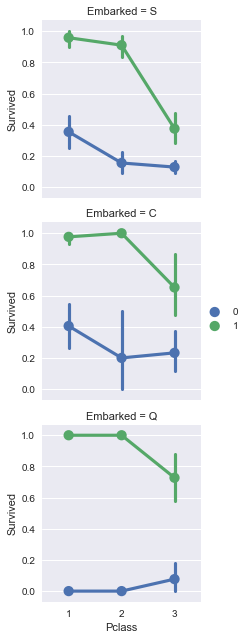

In [79]:
grid_4 = sns.FacetGrid(train, row='Embarked')
grid_4.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid_4.add_legend()

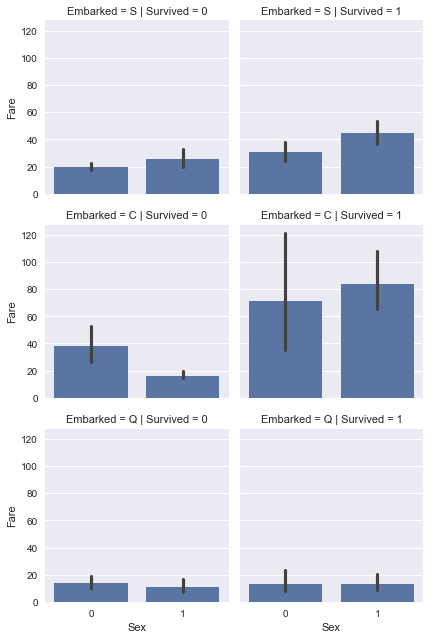

In [80]:
grid_5 = sns.FacetGrid(train, row='Embarked', col='Survived')
grid_5.map(sns.barplot, 'Sex', 'Fare')
grid_5.add_legend()

In [81]:
train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


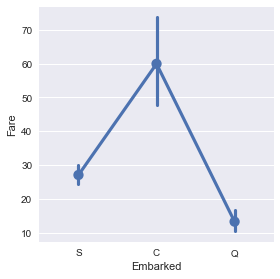

In [82]:
sns.factorplot(
    x='Embarked',
    y='Fare',
    data=train
)

In [83]:
train.loc[(train['Embarked'].isnull())]

,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,IsAlone,Title
61,1,1,1,2,113572,80.0,B28,NaN,1,2
829,1,1,1,3,113572,80.0,B28,NaN,1,3


In [84]:
# high fares, let them be Embarked = 'C'
train.loc[(train['Embarked'].isnull()), 'Embarked'] = 'C'

In [85]:
port_mapping = {
    'S': 0,
    'C': 1,
    'Q': 2
}

for dataset in complete:
    dataset['Embarked'] = dataset['Embarked'].map(port_mapping).astype(np.int)
    
train.head()

,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,IsAlone,Title
0,0,3,0,1,A/5 21171,7.2500,NaN,0,0,1
1,1,1,1,2,PC 17599,71.2833,C85,1,0,3
2,1,3,1,1,STON/O2. 3101282,7.9250,NaN,0,1,2
3,1,1,1,2,113803,53.1000,C123,0,0,3
4,0,3,0,2,373450,8.0500,NaN,0,1,1


#### 7. Fare

In [86]:
test['Fare'].fillna(test['Fare'].dropna().median(), inplace=True)

In [87]:
# qcut() for quantity cut

train['FareBin'], fare_bin = pd.qcut(train['Fare'], 4, retbins=True)
train['FareBin'] = train['FareBin'].astype(str)
fare_group = train[['FareBin', 'Survived']].groupby(['FareBin'], as_index=False).mean()
fare_group

,FareBin,Survived
0,"(14.454, 31]",0.454955
1,"(31, 512.329]",0.581081
2,"(7.91, 14.454]",0.303571
3,"[0, 7.91]",0.197309


In [88]:
test['FareBin'] = pd.cut(test['Fare'], bins=fare_bin, include_lowest=True)
test['FareBin'] = test['FareBin'].astype(str)

fare_bin_map = {v: k for k, v in fare_group.to_dict()['FareBin'].items()}
fare_bin_map

{'(14.454, 31]': 0, '(31, 512.329]': 1, '(7.91, 14.454]': 2, '[0, 7.91]': 3}

In [89]:
for dataset in complete:

    dataset['Fare'] = dataset['FareBin'].map(fare_bin_map).astype(np.int)
    
train = train.drop(['FareBin'], axis=1)
test = test.drop(['FareBin'], axis=1)
complete = [train, test]

train.head(10)

,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,IsAlone,Title
0,0,3,0,1,A/5 21171,3,NaN,0,0,1
1,1,1,1,2,PC 17599,1,C85,1,0,3
2,1,3,1,1,STON/O2. 3101282,2,NaN,0,1,2
3,1,1,1,2,113803,1,C123,0,0,3
4,0,3,0,2,373450,2,NaN,0,1,1
5,0,3,0,1,330877,2,NaN,2,1,1
6,0,1,0,3,17463,1,E46,0,1,1
7,0,3,0,0,349909,0,NaN,0,0,4
8,1,3,1,1,347742,2,NaN,0,0,3
9,1,2,1,0,237736,0,NaN,1,0,3


In [90]:
test.head(10)

,PassengerId,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,IsAlone,Title
0,892,3,0,2,330911,3,NaN,2,1,1
1,893,3,1,2,363272,3,NaN,0,0,3
2,894,2,0,3,240276,2,NaN,2,1,1
3,895,3,0,1,315154,2,NaN,0,1,1
4,896,3,1,1,3101298,2,NaN,0,0,3
5,897,3,0,0,7538,2,NaN,0,1,1
6,898,3,1,1,330972,3,NaN,2,1,2
7,899,2,0,1,248738,0,NaN,0,0,1
8,900,3,1,1,2657,3,NaN,1,1,3
9,901,3,0,1,A/4 48871,0,NaN,0,0,1


#### 8. Cabin / Ticket

    - Drop unnecessary features
    - Cabin: contains many missing values
    - Ticket: high ratio of duplicates, might contain noise and should not correlate to survival

In [91]:
train = train.drop(['Ticket', 'Cabin'], axis=1)
test = test.drop(['Ticket', 'Cabin'], axis=1)
complete = [train, test]

##### Pearson Correlation Heatmap

Gender and title and most correlated to survival, they're also highly correlated to each other

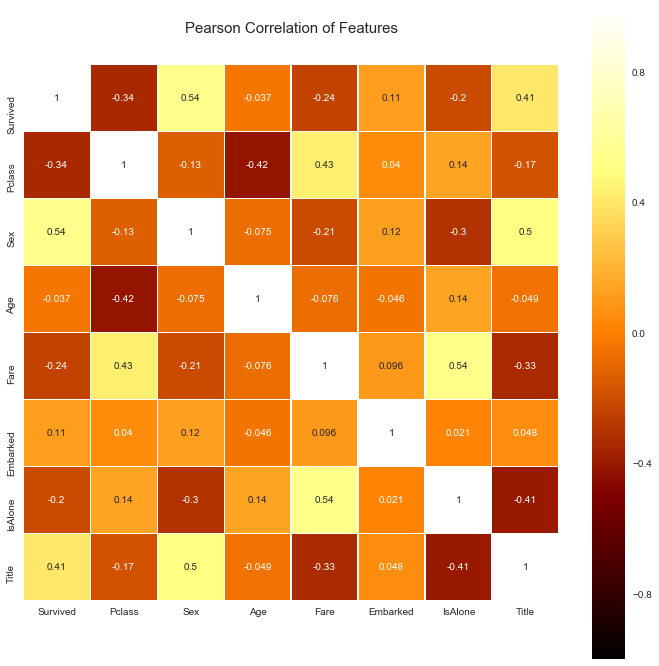

In [92]:
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(
    train.astype(float).corr(),
    linewidths=0.1,
    vmax=1.0,
    square=True,
    cmap=plt.cm.afmhot,
    linecolor='white',
    annot=True
)

### Modeling

In [93]:
X_train = train.drop(['Survived'], axis=1)
Y_train = train['Survived']
x_test = test.drop(['PassengerId'], axis=1)

##### Logistic Regression

In [94]:
logreg_clf = LogisticRegression()
logreg_clf.fit(X_train, Y_train)

logreg_accuracy = round(logreg_clf.score(X_train, Y_train) * 100, 2)
logreg_accuracy

81.260000000000005

In [95]:
# Export csv and submit to Kaggle

submission['Survived'] = logreg_clf.predict(x_test)
submission.to_csv('gender_submission_logreg.csv', index=False)

# 0.76555

##### Support Vector Machine

In [96]:
svm_clf = SVC(
    C=1.0,
    cache_size=200,
    class_weight=None,
    coef0=0.0,
    degree=2,
    decision_function_shape=None,
    gamma=0.1,
    kernel='rbf',
    max_iter=-1,
    probability=False,
    random_state=None,
    shrinking=True,
    tol=0.001,
    verbose=False
)
svm_clf = svm_clf.fit(X_train, Y_train)

svm_accuracy = round(svm_clf.score(X_train, Y_train) * 100, 2)
svm_accuracy

82.150000000000006

In [97]:
# Export csv and submit to Kaggle

submission['Survived'] = svm_clf.predict(x_test)
submission.to_csv('gender_submission_svm.csv', index=False)

# 0.78947

##### Decision Tree

In [98]:
tree_clf = DecisionTreeClassifier(
    criterion='gini',
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1
)
tree_clf = tree_clf.fit(X_train, Y_train)

tree_accuracy = round(tree_clf.score(X_train, Y_train) * 100, 2)
tree_accuracy

83.5

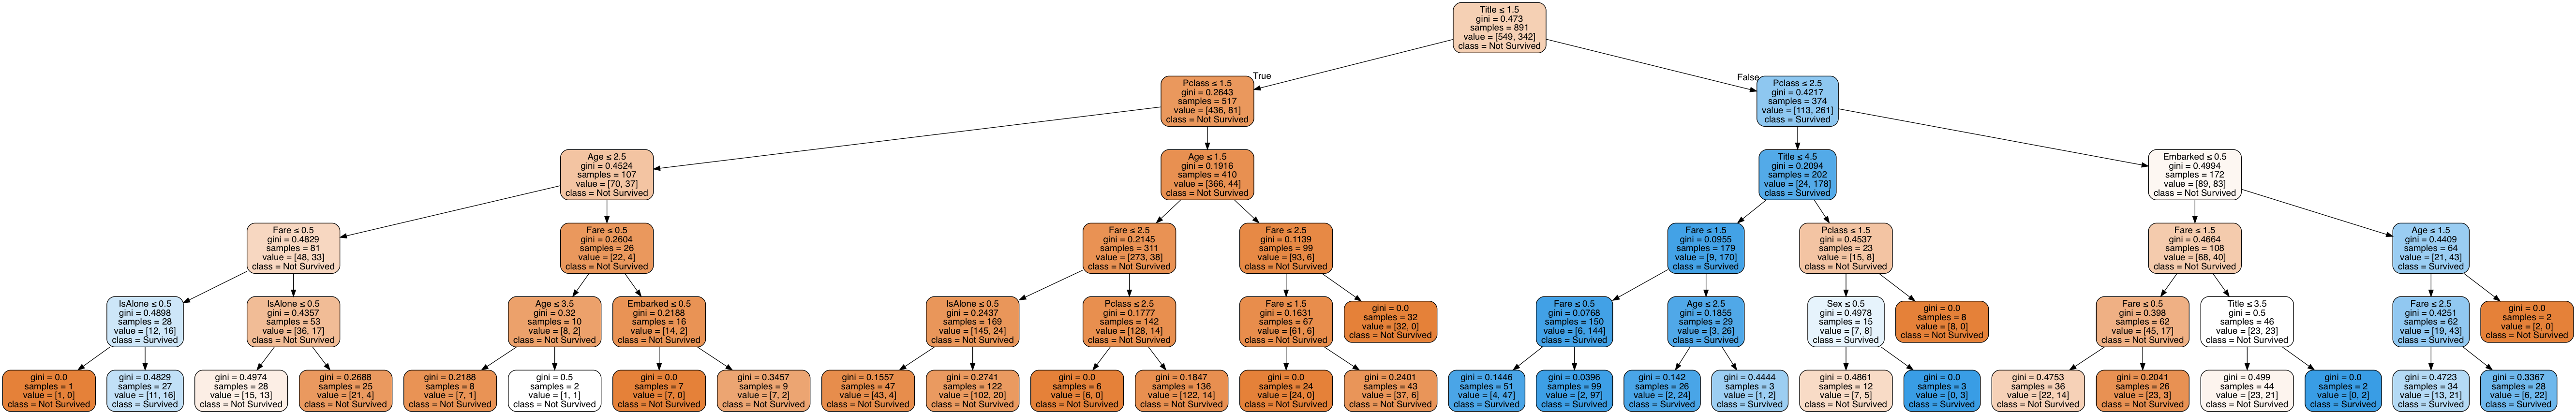

In [99]:
# Draw the Decision Tree
# The result tells us that title has the most information gain in the first level of the tree
# How to interpret the graph: http://www.techtrek.io/machine-learning-part-2-visualizing-a-decision-tree/

import pydotplus
from IPython.display import Image

dot_data = export_graphviz(
    tree_clf,
    out_file=None,
    feature_names=X_train.columns.values,
    class_names=['Not Survived', 'Survived'],
    filled=True,
    rounded=True,
    special_characters=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [100]:
# Export csv and submit to Kaggle

submission['Survived'] = tree_clf.predict(x_test)
submission.to_csv('gender_submission_tree.csv', index=False)

# 0.77033

##### Random Forest

In [101]:
forest_clf = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    max_features=2,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=True
)
forest_clf = forest_clf.fit(X_train, Y_train)

forest_accuracy = round(forest_clf.score(X_train, Y_train) * 100, 2)
forest_accuracy

86.760000000000005

In [102]:
# Export csv and submit to Kaggle

submission['Survived'] = forest_clf.predict(x_test)
submission.to_csv('gender_submission_forest.csv', index=False)

# 0.78469

### Model Evaluation

In [103]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Supprt Vector Machine', 'Decision Tree', 'Random Forest'],
    'Confidence': [logreg_accuracy, svm_accuracy, tree_accuracy, forest_accuracy],
    'Score': [0.76555, 0.78947, 0.77033, 0.78469]
})

models = models[['Model', 'Confidence', 'Score']]

models.sort_values(by='Score', ascending=False)

,Model,Confidence,Score
1,Supprt Vector Machine,82.15,0.78947
3,Random Forest,86.76,0.78469
2,Decision Tree,83.50,0.77033
0,Logistic Regression,81.26,0.76555
